In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 10 09:26:41 2019

@author: mengxiangyu
"""
import numpy as np
from scipy.sparse import diags
from numpy.linalg import inv
import math as m
#import bs_options as bs
import matplotlib.pyplot as plt

#%matplotlib inline


class op_cknl:
    N = 200
    J = 500
    def __init__(self,CallFlag = True,\
                 EuroFlag = True,S0 = 80,K = 90,\
              T = 5,vol = 0.5,r = 0.05,\
              d = 0.05):
        #Basic Parameters
        self.CallFlag = CallFlag
        self.EuroFlag = EuroFlag
        self.S0 = S0
        self.K = K
        self.T = T
        self.vol = vol
        self.r = r
        self.d = d

        #Numerical Method for PDE
        self.x_max = vol * np.sqrt(T) * 5
        self.dx = 2 * self.x_max / op_cknl.N
        self.x = np.linspace(-self.x_max, self.x_max, op_cknl.N + 1)
        self.dt = T / op_cknl.J
        self.Tau = np.arange(op_cknl.J) * self.dt
        self.S = np.exp(self.x) * self.S0
        self.mu = r - d - 0.5 * vol**2

        #Parameters of discretized PDE
        self.pa = -0.25 * ((vol**2) / (self.dx**2) + self.mu / self.dx)
        self.pb = 1 / self.dt + (vol**2) / (2 * self.dx**2)
        self.pc = -0.25 * ((vol**2) / (self.dx**2) - self.mu / self.dx)
        self.pd = -self.pa
        self.pe = 1 / self.dt - r - 0.5 * (vol**2) / (self.dx**2)
        self.pf = -self.pc

        #Vectorized Parameters of discretized PDE
        self.va = [self.pa] * (op_cknl.N + 1)
        self.vb = [self.pb] * (op_cknl.N + 1)
        self.vc = [self.pc] * (op_cknl.N + 1)
        self.vd = [self.pd] * (op_cknl.N + 1)
        self.ve = [self.pe] * (op_cknl.N + 1)
        self.vf = [self.pf] * (op_cknl.N + 1)

        #Parameter Matrices
        self.A = diags([self.ve, self.vd[:-1], self.vf[1:]],
                       [0, 1, -1]).toarray()
        self.B = diags([self.vb, self.va[:-1], self.vc[1:]],
                       [0, 1, -1]).toarray()

    def delta(self, vm, n_mid):
        return ((vm[-1][2]-vm[-1][0])/\
            (2*self.dx)+(vm[-2][2]-vm[-2][0])/(2*self.dx))\
                /2/(self.S[n_mid])

    #@classmethod
    def gamma(self, vm, n_mid):
        dv2_dx2=(vm[-1][2]+vm[-1][0]-2*vm[-1][1]+\
             vm[-2][2]+vm[-2][0]-2*vm[-2][1])/(2*self.dx**2)
        dx_ds = 1 / self.S[n_mid]
        dv_dx = ((vm[-1][2]-vm[-1][0])/\
             (2*self.dx)+(vm[-2][2]-vm[-2][0])/(2*self.dx))/2
        dx2_ds_2 = -1 / self.S[n_mid]**2
        return dv2_dx2 * dx_ds**2 + dv_dx * dx2_ds_2

    #@classmethod
    def theta(self, vm):
        return (vm[-1][0] - vm[-2][0]) / self.dt

    def option_price_greek(self):
        if self.CallFlag == True and self.EuroFlag == True:
            #European Call Options Pricing
            V = np.clip(np.exp(self.x) * self.S0 - self.K, 0, 1e10)
            Binv = np.linalg.inv(self.B)
            V_midec = []
            n_mid = int(op_cknl.N / 2)
            cut = int(op_cknl.N / 4)
            for j in range(op_cknl.J):
                V = Binv.dot(self.A).dot(V)
                V[0] = 0
                V[op_cknl.N] = np.exp(self.x_max) *self.S0* np.exp(
                    -self.d * j * self.dt)  - self.K * np.exp(
                    -self.r * j * self.dt)
                if j % 50 == 0:
                    plt.plot(self.S0 * np.exp(self.x[cut:-cut]), V[cut:-cut])
                V_midec.append([V[n_mid - 1], V[n_mid], V[n_mid + 1]])
            price = V[n_mid]
            delta = self.delta(V_midec, n_mid)
            gamma = self.gamma(V_midec, n_mid)
            theta = self.theta(V_midec)
            result = [price, delta, gamma, theta]
        elif self.CallFlag == True and self.EuroFlag == False:
            #American Call Options Pricing
            V0 = np.clip(self.S0 * np.exp(self.x) - self.K, 0, 1e10)
            V = V0.copy()
            V_midac = []
            Binv = np.linalg.inv(self.B)
            n_mid = int(op_cknl.N / 2)
            cut = int(op_cknl.N / 4)
            for j in range(op_cknl.J):
                V = Binv.dot(self.A).dot(V)
                V = np.where(V < V0, V0, V)
                if j % 50 == 0:
                    plt.plot(self.S0 * np.exp(self.x[cut:-cut]), V[cut:-cut])
                V_midac.append([V[n_mid - 1], V[n_mid], V[n_mid + 1]])
            price = V[n_mid]
            delta = self.delta(V_midac, n_mid)
            gamma = self.gamma(V_midac, n_mid)
            theta = self.theta(V_midac)
            result = [price, delta, gamma, theta]

        elif self.CallFlag == False and self.EuroFlag == True:
            #European Put Options Pricing
            V = np.clip(self.K - np.exp(self.x) * self.S0, 0, 1e10)
            Binv = np.linalg.inv(self.B)
            V_midep = []
            n_mid = int(op_cknl.N / 2)
            cut = int(op_cknl.N / 4)
            #V = S
            for j in range(op_cknl.J):
                V = Binv.dot(self.A).dot(V)
                V[op_cknl.N] = 0
                V[0] = np.exp(self.x_max) * self.S0* np.exp(
                    -self.d * j * self.dt)  - self.K * np.exp(
                    -self.r * j * self.dt)
                if j % 50 == 0:
                    plt.plot(self.S0 * np.exp(self.x[cut:-cut]), V[cut:-cut])
                V_midep.append([V[n_mid - 1], V[n_mid], V[n_mid + 1]])

            price = V[n_mid]
            delta = self.delta(V_midep, n_mid)
            gamma = self.gamma(V_midep, n_mid)
            theta = self.theta(V_midep)
            result = [price, delta, gamma, theta]
        elif self.CallFlag == False and self.EuroFlag == False:
            #American Put Options Pricing
            V0 = np.clip(self.K - self.S0 * np.exp(self.x), 0, 1e10)
            V = V0.copy()
            Binv = np.linalg.inv(self.B)
            V_midap = []
            n_mid = int(op_cknl.N / 2)
            cut = int(op_cknl.N / 4)
            for j in range(op_cknl.J):
                V = Binv.dot(self.A).dot(V)
                V = np.where(V < V0, V0, V)
                
                
                if j % 50 == 0:
                    plt.plot(self.S0 * np.exp(self.x[cut:-cut]), V[cut:-cut])
                V_midap.append([V[n_mid - 1], V[n_mid], V[n_mid + 1]])

            price = V[n_mid]
            delta = self.delta(V_midap, n_mid)
            gamma = self.gamma(V_midap, n_mid)
            theta = self.theta(V_midap)
            result = [price, delta, gamma, theta]
        return result

In [19]:
euro_put = op_cknl(False, True, 110, 100, 1, 0.3, 0.05, 0)

The option price is  6.184154879315177
The delta is  -0.2629555087704485
The gamma is  0.009895884523018348
The theta is  3.6275266850305243


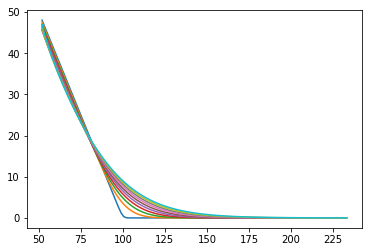

In [20]:
result = euro_put.option_price_greek()
print('The option price is ', result[0])
print('The delta is ', result[1])
print('The gamma is ', result[2])
print('The theta is ', result[3])

In [14]:
euro_call = op_cknl(True, True, 90, 100, 1, 0.3, 0.01, 0.15)

The option price is  3.0358922790864344
The delta is  0.21704698624788543
The gamma is  0.010184661086390871
The theta is  0.9785010512235459


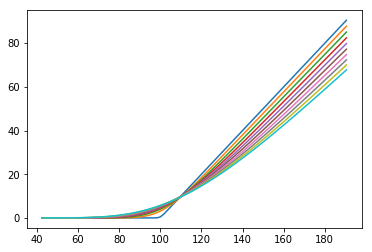

In [15]:
result = euro_call.option_price_greek()
print('The option price is ', result[0])
print('The delta is ', result[1])
print('The gamma is ', result[2])
print('The theta is ', result[3])

In [12]:
amer_put = op_cknl(False, False, 110, 100, 1, 0.3, 0.05, 0)

The option price is  6.470454832988053
The delta is  -0.27962623330049075
The gamma is  0.010865090012128643
The theta is  4.075158064431594


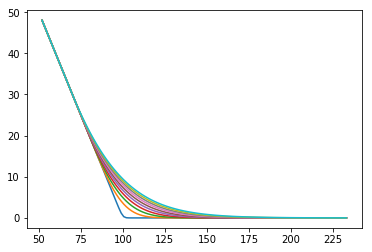

In [13]:
result = amer_put.option_price_greek()
print('The option price is ', result[0])
print('The delta is ', result[1])
print('The gamma is ', result[2])
print('The theta is ', result[3])

In [8]:
amer_call = op_cknl(True, False, 90, 100, 1, 0.3, 0.01, 0.15)

The option price is  3.7082511953999058
The delta is  0.2802970365726331
The gamma is  0.014889665386791222
The theta is  1.8117594982929308


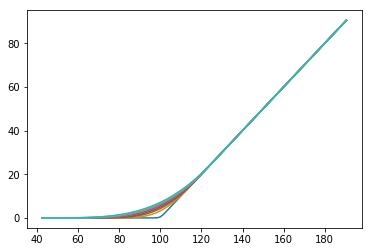

In [9]:
result = amer_call.option_price_greek()
print('The option price is ', result[0])
print('The delta is ', result[1])
print('The gamma is ', result[2])
print('The theta is ', result[3])